In [1]:
import subprocess
import os
import pandas as pd

folder = 'extraido'

csvs = [f for f in os.listdir(folder) if f.endswith('.csv')]
csvs

df = pd.DataFrame()
for csv in csvs:
  new_df = pd.read_csv(f'extraido/{csv}', sep=';').sort_values(by='data')
  df = pd.concat([df, new_df])

len(df)


9294694

In [2]:
df.dtypes

regiao                     object
estado                     object
municipio                  object
coduf                       int64
codmun                    float64
codRegiaoSaude            float64
nomeRegiaoSaude            object
data                       object
semanaEpi                   int64
populacaoTCU2019          float64
casosAcumulado            float64
casosNovos                  int64
obitosAcumulado             int64
obitosNovos                 int64
Recuperadosnovos          float64
emAcompanhamentoNovos     float64
interior/metropolitana    float64
dtype: object

In [3]:
from scipy.interpolate import interp1d
import numpy as np
import pandas as pd

def smooth_covid(Tx, x, w):
    # Convert datetime to numeric (timestamps)
    Tx_numeric = pd.to_datetime(Tx).astype(np.int64) // 10**9  # Convert to seconds since epoch

    # Identify indices where data is non-zero or non-null
    iz = np.where(np.diff(x) != 0)[0] + 1
    iz_first, iz_last = iz[0], iz[-1]
    
    Tz = Tx_numeric[iz]
    z = x[iz]

    # Interpolate with NaN handling
    interpolator = interp1d(Tz, z, kind='linear', fill_value="extrapolate")
    y_interp_NaN = interpolator(Tx_numeric)  # Apply interpolation on numeric datetime
    y_interp = np.copy(x)
    y_interp[iz_first:iz_last] = y_interp_NaN[iz_first:iz_last]

    # Smooth the interpolated data
    y_smoothed = pd.Series(y_interp).rolling(window=w, center=True).mean().to_numpy()
    
    return y_smoothed, y_interp, Tx, z

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from matplotlib.dates import DateFormatter

def save_figs(df1, df2, population_col, cases_col, date_col, df1_legend, df2_legend):
  # Me = pd.read_csv('MG.csv', sep=';').sort_values(by='date')
  population_df1 = df1[population_col].max()
  cases_df1 = (df1[cases_col] / population_df1 * 1e5).values
  dates_df1 = pd.to_datetime(df1[date_col].values)
  smoothed_df1, *_ = smooth_covid(dates_df1, cases_df1, 7)
  df_plot1 = pd.DataFrame({"values": smoothed_df1, "dates": dates_df1}).sort_values(by="dates")
  

  # Mc = pd.read_excel('PARACATU.xlsx').sort_values(by='date')
  population_df2 = df2[population_col].max()
  cases_df2 = (df2[cases_col] / population_df2 * 1e5).values
  y = np.concatenate([np.zeros(len(cases_df1) - len(cases_df2)), cases_df2])  # Align lengths by padding with zeros
  smoothed_df2, *_ = smooth_covid(dates_df1, y, 7)
  df_plot2 = pd.DataFrame({"values": smoothed_df1, "dates": dates_df1}).sort_values(by="dates")

  # Calculate differences and signed square differences
  d_nnC = smoothed_df2 - smoothed_df1
  df_plot3 = pd.DataFrame({"values": d_nnC, "dates": dates_df1}).sort_values(by="dates")
  ssd_nnC = np.sign(d_nnC) * (d_nnC ** 2) / 1e5
  df_plot4 = pd.DataFrame({"values": ssd_nnC, "dates": dates_df1}).sort_values(by="dates")

  # Generate dynamic date ticks and labels
  # DATE_ticks = pd.date_range(start="2020-04-01", periods=13, freq="MS")
  # DATE_ticklabels = DATE_ticks.strftime('%b/%y')

  # Create plots
  fig, axs = plt.subplots(3, 1, figsize=(16, 10), sharex=True)
  plt.rcParams.update({'axes.titlesize': 10, 'axes.labelsize': 9, 'axes.labelpad': 10})

  # Plot configurations
  plot_params = [
      (df_plot1, df_plot2, "Surveillance", [-600, 6000], [0, 6000], ['$0$', '$6\\times10^3$']),
      (df_plot3, None, "Difference", [-100, 1000], [0, 1000], ['$0$', '$10^3$']),
      (df_plot4 , None, "SSD", [-1, 10], [0, 10], ['$0$', '$10^5$'])
  ]

  for ax, (data1, data2, ylabel, ylim, yticks, yticklabels) in zip(axs, plot_params):
      ax.plot(data1["dates"], data1["values"], 'r', linewidth=2)
      if data2 is not None:
          ax.plot(data1["dates"], data2["values"], 'k', linewidth=2)
          ax.legend([df1_legend, df2_legend], loc='upper left', frameon=False)
      ax.axhline(0, linestyle='--', color=[0.6, 0.6, 0.6])
      # ax.set_ylim(ylim)
      # ax.set_yticks(yticks)
      # ax.set_yticklabels(yticklabels)
      # ax.set_ylabel(ylabel, rotation=90)

  # Set x-axis tick labels on the last subplot
  # axs[-1].set_xticks(DATE_ticks)
  # axs[-1].set_xticklabels(DATE_ticklabels, rotation=45)

  plt.tight_layout()
  plt.show()

  # Uncomment to save as a PDF
  fig.savefig('figuras', format='pdf', bbox_inches='tight')
  return df_plot1, df_plot2

# Figura sem suavização

Essa figura são os dados crus, sem suavização. Não temos essa figura no paper.

/home/carlos/Documents/git/covid/venv/lib/python3.12/site-packages/scipy/interpolate/_interpolate.py:479: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/home/carlos/Documents/git/covid/venv/lib/python3.12/site-packages/scipy/interpolate/_interpolate.py:482: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


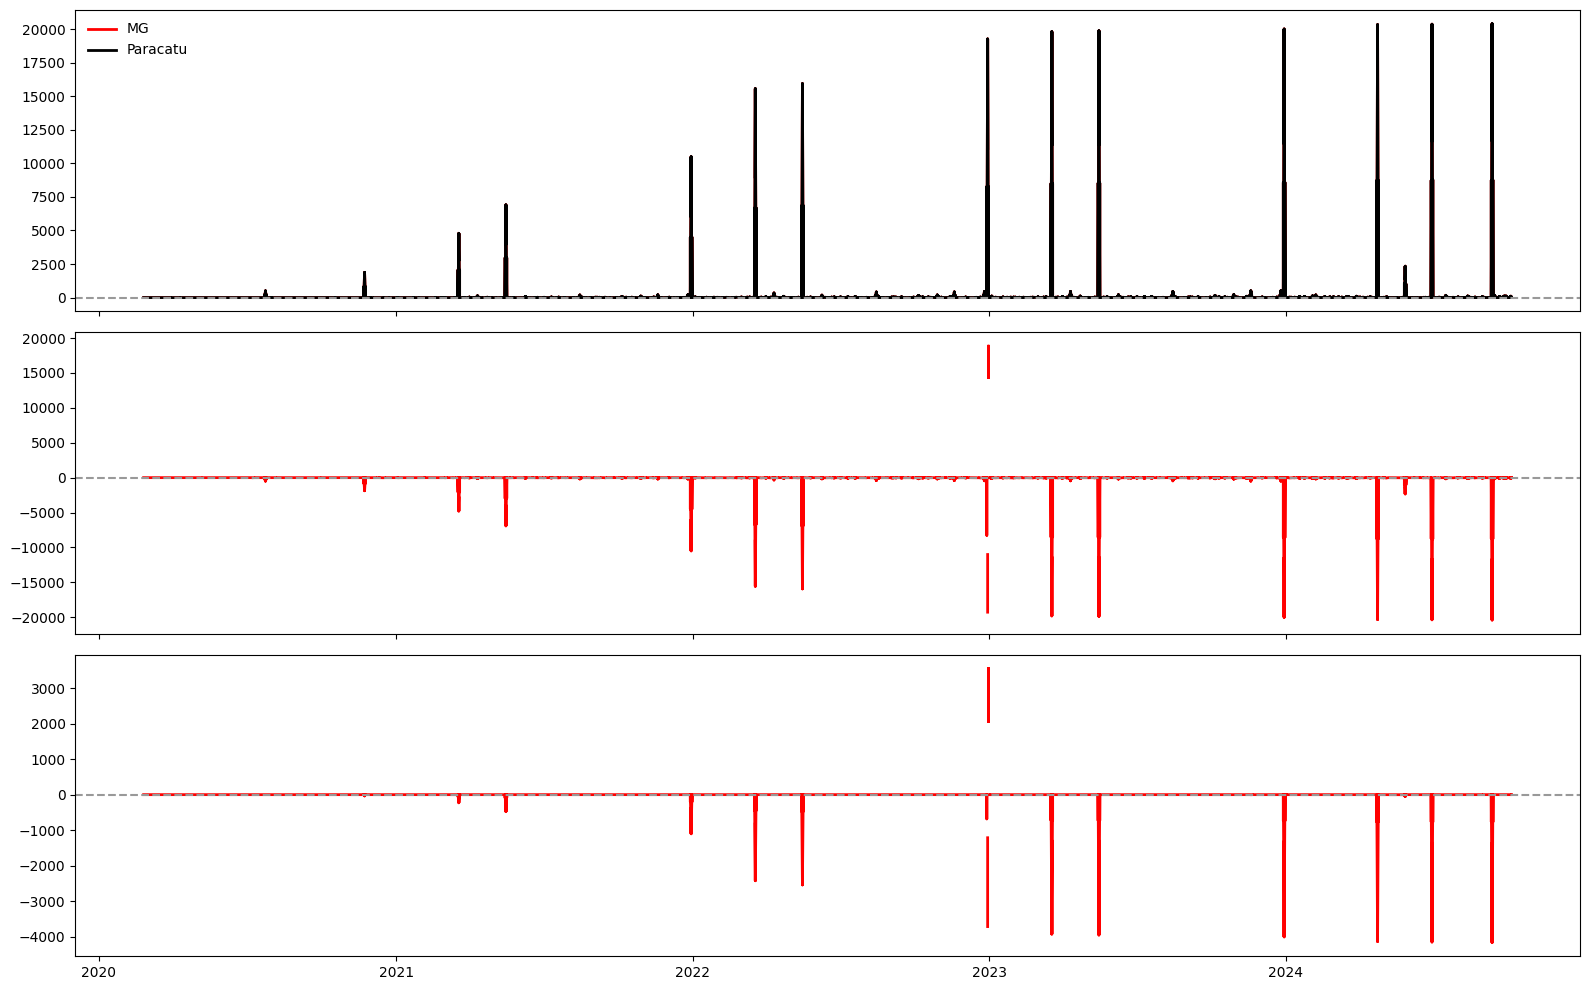

In [5]:
# df1 = pd.read_csv('MG.csv', sep=';').sort_values(by='date')
# df2 = pd.read_excel('PARACATU.xlsx').sort_values(by='date')

df1 = df[df['estado'] == 'MG']
df2 = df[df['municipio'] == 'Paracatu']

_, _ = save_figs(df1, df2, 'populacaoTCU2019', 'casosAcumulado', 'data', 'MG', 'Paracatu')

# Dados suavizados antes de plotar

Esse é estado de MG suavizado e com o mesmo período do paper.

In [6]:
smoth_factor = 2 # Fator suavizante

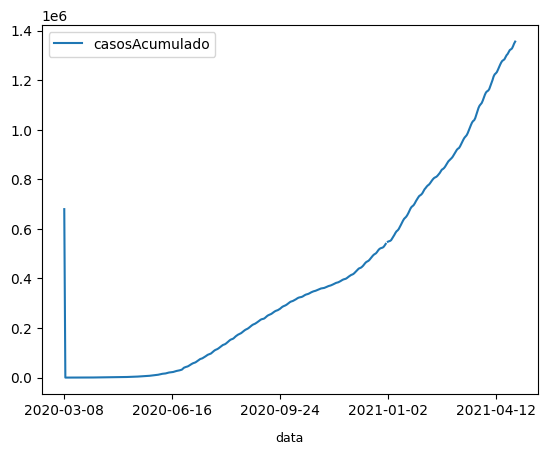

In [7]:
df1 = df[(df['estado'] == 'MG') & (df['data'] >= '2020-03-08') & (df['data'] <= '2021-04-31') & (df['populacaoTCU2019'].notna()) & (df['municipio'].isna())].reset_index()
values, *_ = smooth_covid(df1['data'].values, df1['casosAcumulado'].values, smoth_factor)
smoothed_df1 = df1.copy()
smoothed_df1['casosAcumulado'] = values

_ = smoothed_df1.sort_values(by="data").plot(x='data', y='casosAcumulado')

Cidade de Paracatu suavizada.

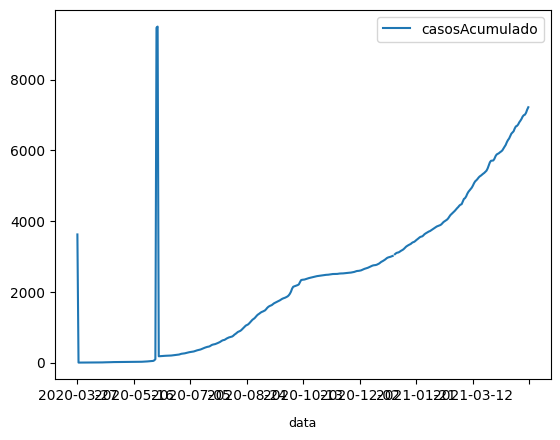

In [8]:
df2 = df[(df['municipio'] == 'Paracatu') & (df['data'] >= '2020-03-08') & (df['data'] <= '2021-04-31')].reset_index() #& (df['casosAcumulado'] < 600)
values, *_ = smooth_covid(df2['data'].values, df2['casosAcumulado'].values, smoth_factor)
smoothed_df2 = df2.copy()
smoothed_df2['casosAcumulado'] = values

_ = smoothed_df2.sort_values(by="data").plot(x='data', y='casosAcumulado')

# Figura sem suavização, mas filtrada.

Essa figura deveria ser igual a figura_valida.png (Figura 3 do paper).

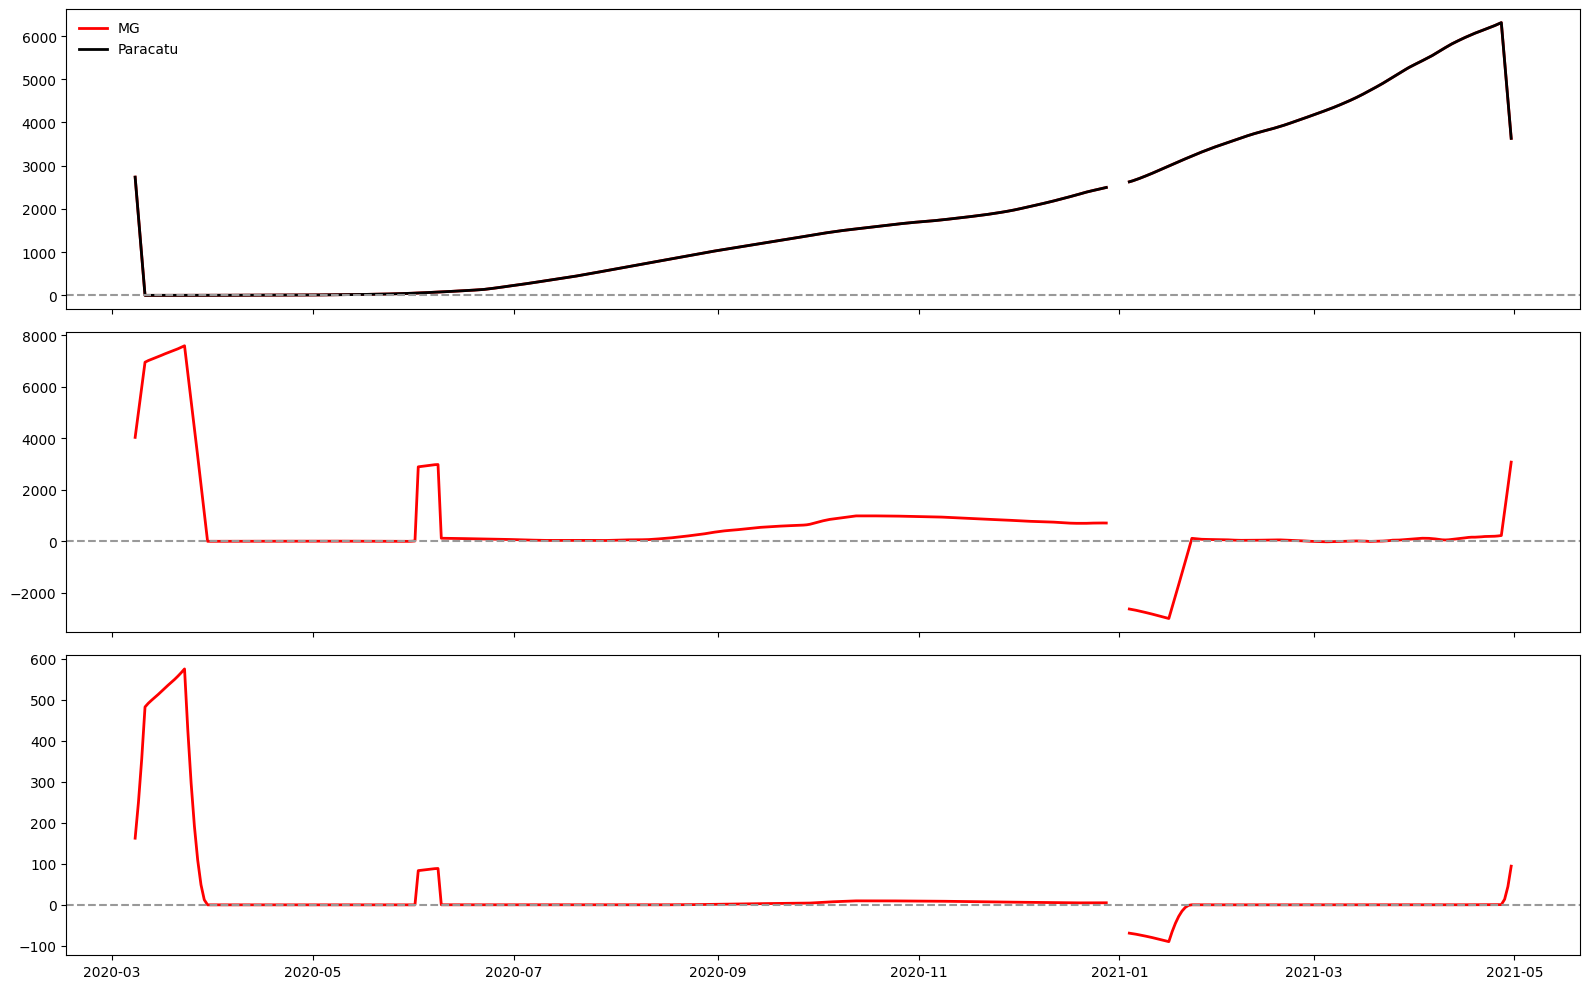

In [9]:
df_smothed1, df_smothed2 = save_figs(df1, df2, 'populacaoTCU2019', 'casosAcumulado', 'data', 'MG', 'Paracatu')

# Figura com dados duplamente suavizados

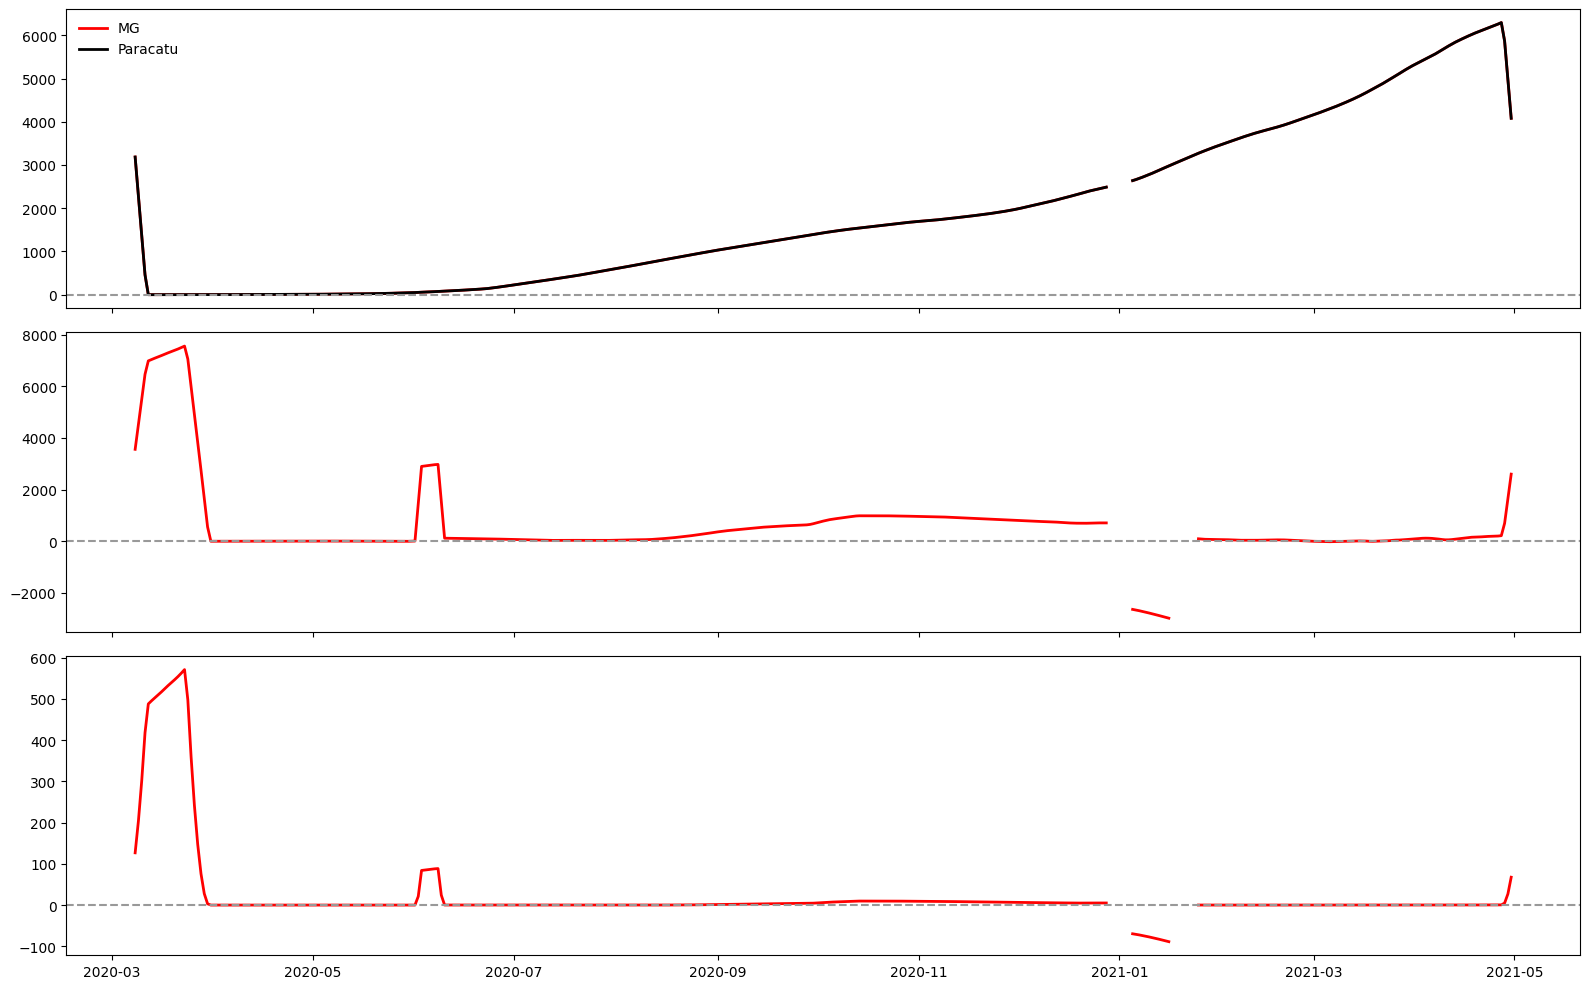

In [ ]:
_, _ = save_figs(smoothed_df1, smoothed_df2, 'populacaoTCU2019', 'casosAcumulado', 'data', 'MG', 'Paracatu')

# Remocao de outliers

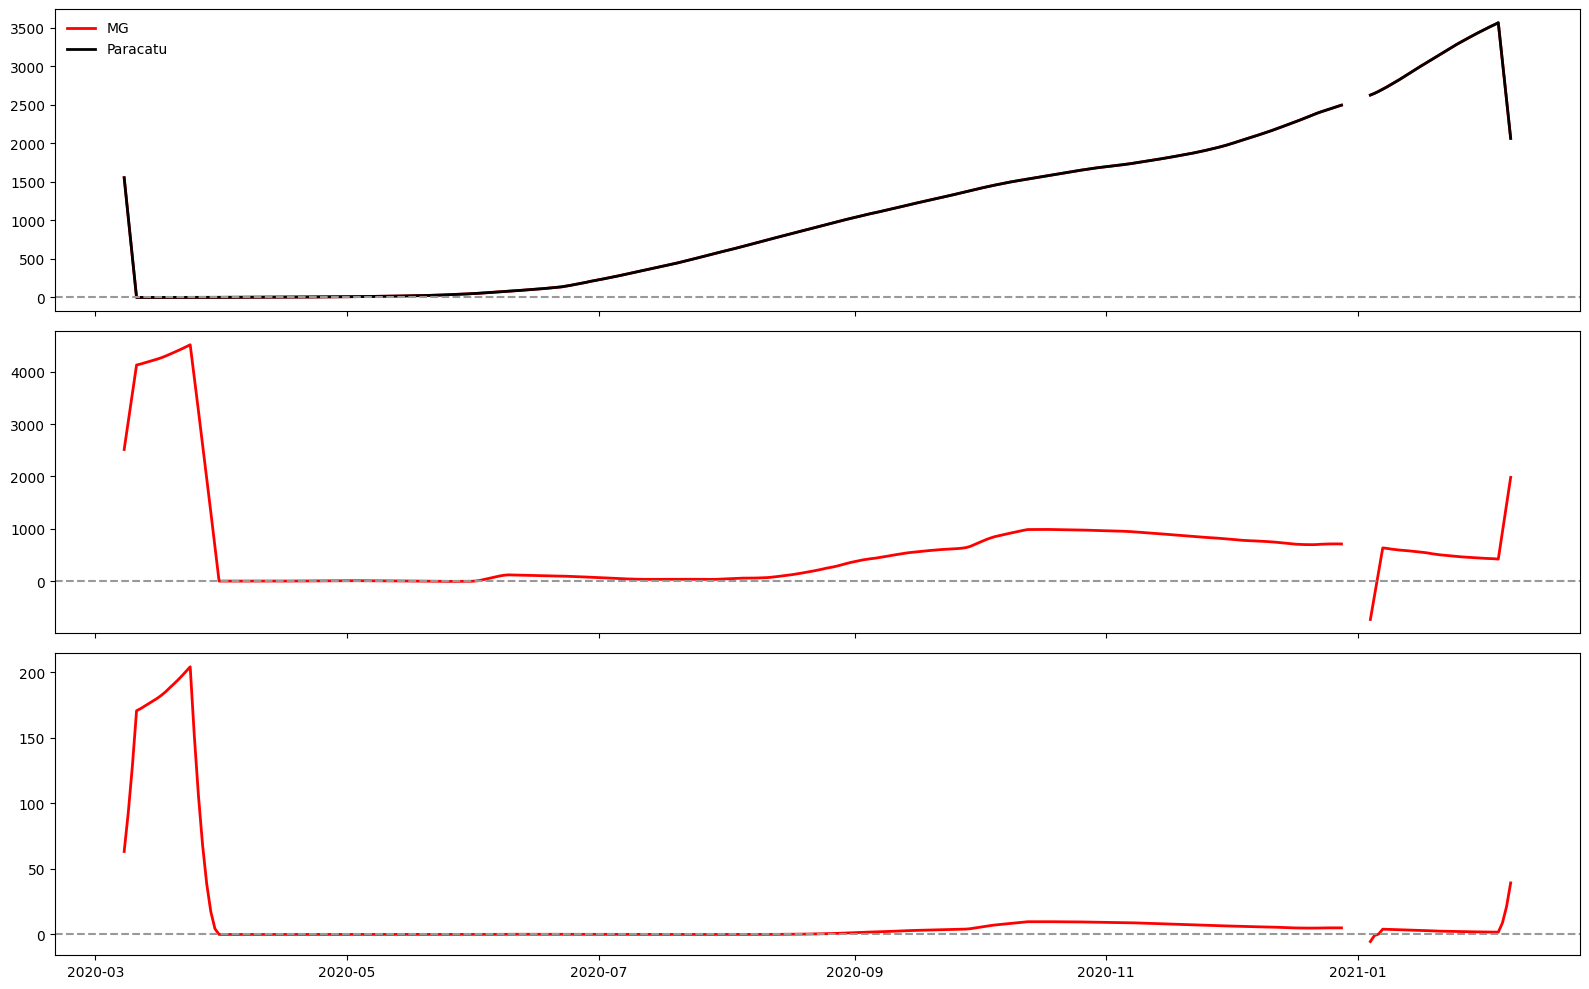

In [13]:
df1_out = df1[df1['casosAcumulado'] <= (2 * df1['casosAcumulado'].std())] 
df2_out = df2[df2['casosAcumulado'] <= (2 * df2['casosAcumulado'].std())]

_, _ = save_figs(df1_out, df2_out, 'populacaoTCU2019', 'casosAcumulado', 'data', 'MG', 'Paracatu')